In [1]:
import pandas as pd
import numpy as np 
from gpxutils import parse_gpx 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Pending To-Do's
- replace speed outlier with average around it
- describe each plot
- add more explainable and detailed visualisation
- re-do summaries: road races are actually supposed to be faster due to groups of riders pulling each other
- use insert() to specify where calculated columns should be

# Analysis of Cycling Data

We are provided with four files containing recordings of cycling activities that include GPS location data as
well as some measurements related to cycling performance like heart rate and power.  The goal is to perform
some exploration and analysis of this data. 

The data represents four races.  Two are time trials where the rider rides alone on a set course.  Two are 
road races where the rider rides with a peleton.  All were held on the same course but the road races include
two laps where the time trials include just one. 

Questions to explore with the data:
* What is the overall distance travelled for each of the rides? What are the average speeds etc.  Provide a summary for each ride.
* Compare the range of speeds for each ride, are time trials faster than road races? 
* Compare the speeds achieved in the two time trials (three years apart).  As well as looking at the averages, can you see where in the ride one or the other is faster.  
* From the elevation_gain field you can see whether the rider is _climbing_ , _descending_ or on the _flat_.   Use this to calculate the average speeds in those three cases (climbing, flat or descending).  Note that _flat_ might not be zero elevation_gain but might allow for slight climbs and falls.  

For time varying data like this it is often useful to _smooth_ the data using eg. a [rolling mean](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.rolling_mean.html).  You might want to experiment with smoothing in some of your analysis (not required but may be of interest).

## Description of Fields

* _index_ is a datetime showing the time that the observation was made (I wasn't riding at night, this is converted to UTC)
* __latitude, longitude, elevation__ from the GPS, the position of the rider at each timepoint, elevation in m
* __temperature__ the current ambient temperature in degrees celcius
* __power__ the power being generated by the rider in Watts
* __cadence__ the rotational speed of the pedals in revolutions per minute
* __hr__ heart rate in beats per minute
* __elevation_gain__ the change in elevation in m between two observations
* __distance__ distance travelled between observations in km
* __speed__ speed measured in km/h

You are provided with code in [gpxutils.py](gpxutils.py) to read the GPX XML format files that are exported by cycling computers and applications.  The sample files were exported from [Strava](https://strava.com/) and represent four races by Steve Cassidy.


In [2]:
# read the four data files
rr16 = parse_gpx('files/Calga_RR_2016.gpx') # road race one
tt16 = parse_gpx('files/Calga_TT_2016.gpx') # time trial one
rr19 = parse_gpx('files/Calga_RR_2019.gpx') # road race two
tt19 = parse_gpx('files/Calga_TT_2019.gpx') # time trial two

### 1. Familiarising with the data

In [3]:
rr16.head()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
2016-05-14 04:02:41+00:00,-33.415561,151.222303,208.6,29.0,0.0,40.0,102.0,0.000000,0.0,0.000000,NaN
2016-05-14 04:02:42+00:00,-33.415534,151.222289,208.6,29.0,0.0,40.0,102.0,0.003271,0.0,11.777020,1.0
2016-05-14 04:02:46+00:00,-33.415398,151.222180,208.6,29.0,0.0,40.0,103.0,0.018194,0.0,16.375033,4.0
2016-05-14 04:02:49+00:00,-33.415264,151.222077,208.6,29.0,0.0,55.0,106.0,0.017703,0.0,21.243901,3.0
2016-05-14 04:02:51+00:00,-33.415160,151.222013,208.6,29.0,0.0,61.0,109.0,0.013001,0.0,23.401217,2.0


In [4]:
rr19.head()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
2019-06-22 22:33:45+00:00,-33.416592,151.222853,215.0,0.0,0.0,58.0,71.0,0.000000,0.0,0.000000,NaN
2019-06-22 22:33:46+00:00,-33.416629,151.222877,215.0,0.0,147.0,58.0,71.0,0.004679,0.0,16.842677,1.0
2019-06-22 22:33:47+00:00,-33.416677,151.222905,214.8,0.0,97.0,60.0,71.0,0.005936,-0.2,21.371074,1.0
2019-06-22 22:33:48+00:00,-33.416730,151.222937,214.8,0.0,74.0,61.0,71.0,0.006599,0.0,23.757913,1.0
2019-06-22 22:33:49+00:00,-33.416783,151.222972,214.8,0.0,136.0,62.0,71.0,0.006729,0.0,24.225566,1.0


In [5]:
tt16.head()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
2016-07-02 23:05:30+00:00,-33.415971,151.222016,111.8,12.0,0.0,58.0,108.0,0.000000,0.0,0.000000,NaN
2016-07-02 23:05:32+00:00,-33.416026,151.222008,111.8,12.0,0.0,58.0,105.0,0.006161,0.0,11.089134,2.0
2016-07-02 23:05:38+00:00,-33.416034,151.222023,111.8,12.0,0.0,58.0,105.0,0.001652,0.0,0.991282,6.0
2016-07-02 23:06:01+00:00,-33.416041,151.222038,111.8,13.0,0.0,58.0,100.0,0.001595,0.0,0.249655,23.0
2016-07-02 23:06:02+00:00,-33.416048,151.222053,111.8,13.0,0.0,65.0,101.0,0.001595,0.0,5.742071,1.0


In [6]:
tt19.head()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
2019-06-01 22:54:55+00:00,-33.415798,151.222060,219.4,13.0,0.0,0.0,88.0,0.000000,0.0,0.000000,NaN
2019-06-01 22:54:56+00:00,-33.415782,151.222051,219.4,13.0,0.0,0.0,88.0,0.001965,0.0,7.075656,1.0
2019-06-01 22:54:57+00:00,-33.415767,151.222041,219.4,13.0,0.0,0.0,88.0,0.001909,0.0,6.871582,1.0
2019-06-01 22:54:58+00:00,-33.415751,151.222032,219.4,13.0,0.0,0.0,89.0,0.001965,0.0,7.075656,1.0
2019-06-01 22:54:59+00:00,-33.415735,151.222022,219.4,13.0,0.0,0.0,89.0,0.002007,0.0,7.223997,1.0


### 2. What is the overall distance travelled for each of the rides? What are the average speeds etc. Provide a summary for each ride. Additional features of interest are total time needed and total elevation gain.

#### 2.1 Road Race 2016

In [7]:
# overall statistical summary for road race one in 2016

rr16.describe()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
count,2822.000000,2822.000000,2822.000000,2822.000000,2822.0,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2821.000000
mean,-33.368017,151.225527,232.404465,25.280652,0.0,65.987952,158.394401,0.017381,-0.003756,34.933085,1.843318
std,0.028329,0.006014,29.725934,1.348746,0.0,34.425881,11.304588,0.015695,0.458872,10.738677,1.692364
min,-33.416753,151.211496,176.000000,24.000000,0.0,0.000000,102.000000,0.000000,-1.600000,0.000000,1.000000
25%,-33.393691,151.221912,209.450000,24.000000,0.0,68.000000,151.000000,0.007894,-0.400000,26.656312,1.000000
50%,-33.371820,151.227236,226.100000,25.000000,0.0,79.000000,158.000000,0.011794,0.000000,33.307339,1.000000
75%,-33.342269,151.230069,258.200000,26.000000,0.0,87.000000,166.000000,0.016899,0.400000,42.871885,2.000000
max,-33.316890,151.235131,295.800000,30.000000,0.0,117.000000,205.000000,0.076283,1.200000,92.749036,9.000000


- A maximum speed of over 92 km per hour seems high and could be an error of the computer. After some research that has shown that pro cyclists have maximum speeds in standard races of around 70-80km/h, values above 70km/h will be treated as an outlier and replaced with the assumed maximum value of 70km/h for a non professional cyclist. The underlying assumption is that the computer overshot somehow for some high speeds. That is why a "maximum" speed value will be used instead of a lower average speed.
- maximum recorded heart rate is 205 bpm. This requires further investigation since it seems like an impossible value. The assumption is that a maximum heart rate is 220 minus age which in this case is assumed to be 50. This relates to a maximum heart rate of 170. After allowing for some peak exceptions, all bpm values over 180 will be treated as outliers. They will be replaced with the median value. This metric is used since the distribution is skewed to the right, thus, the median will provide a better proxy for the center of the distribution.

In [8]:
# check for null values

rr16[rr16.isna().any(axis=1)]

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
2016-05-14 04:02:41+00:00,-33.415561,151.222303,208.6,29.0,0.0,40.0,102.0,0.0,0.0,0.0,NaN


Since the missing value for timedelta is due to the start of the race and there is no previous value where a difference could have been calculated from, it will be replaced with 0.<br >
Note: The same procedure will be done for other such null values.

In [9]:
# fill missing value

rr16["timedelta"] = rr16["timedelta"].fillna(0)
rr16[rr16.isna().any(axis=1)]

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta


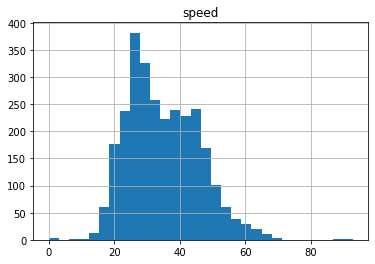

In [10]:
rr16_speed_distribution = rr16.hist('speed', bins=30, histtype='stepfilled')

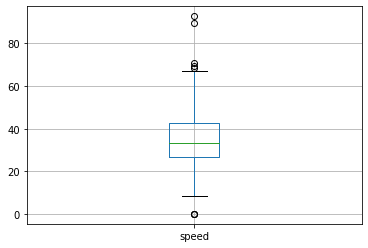

In [11]:
rr16_speed_boxplot = rr16.boxplot('speed')

In [12]:
# replace values over 70

rr16["speed2"] = np.where(rr16["speed"] > 70, 70, rr16["speed"])
rr16_clean = rr16.drop('speed', 1)
rr16_clean.rename(columns={'speed2': 'speed'}, inplace=True)

rr16_clean.describe()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,timedelta,speed
count,2822.000000,2822.000000,2822.000000,2822.000000,2822.0,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000
mean,-33.368017,151.225527,232.404465,25.280652,0.0,65.987952,158.394401,0.017381,-0.003756,1.842665,34.917899
std,0.028329,0.006014,29.725934,1.348746,0.0,34.425881,11.304588,0.015695,0.458872,1.692419,10.674109
min,-33.416753,151.211496,176.000000,24.000000,0.0,0.000000,102.000000,0.000000,-1.600000,0.000000,0.000000
25%,-33.393691,151.221912,209.450000,24.000000,0.0,68.000000,151.000000,0.007894,-0.400000,1.000000,26.656312
50%,-33.371820,151.227236,226.100000,25.000000,0.0,79.000000,158.000000,0.011794,0.000000,1.000000,33.307339
75%,-33.342269,151.230069,258.200000,26.000000,0.0,87.000000,166.000000,0.016899,0.400000,2.000000,42.871885
max,-33.316890,151.235131,295.800000,30.000000,0.0,117.000000,205.000000,0.076283,1.200000,9.000000,70.000000


<AxesSubplot:>

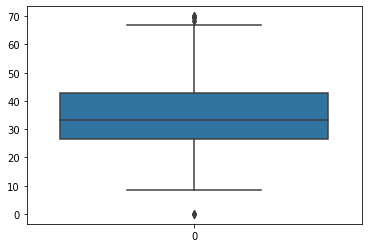

In [13]:
# verify replacement with boxplot
sns.boxplot(data=rr16_clean["speed"])

In [14]:
# replace heart rate values

rr16_clean["hr"] = np.where(rr16_clean["hr"] > 180, rr16_clean["hr"].median(), rr16_clean["hr"])
rr16_clean.describe()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,timedelta,speed
count,2822.000000,2822.000000,2822.000000,2822.000000,2822.0,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000
mean,-33.368017,151.225527,232.404465,25.280652,0.0,65.987952,157.469171,0.017381,-0.003756,1.842665,34.917899
std,0.028329,0.006014,29.725934,1.348746,0.0,34.425881,9.938856,0.015695,0.458872,1.692419,10.674109
min,-33.416753,151.211496,176.000000,24.000000,0.0,0.000000,102.000000,0.000000,-1.600000,0.000000,0.000000
25%,-33.393691,151.221912,209.450000,24.000000,0.0,68.000000,151.000000,0.007894,-0.400000,1.000000,26.656312
50%,-33.371820,151.227236,226.100000,25.000000,0.0,79.000000,158.000000,0.011794,0.000000,1.000000,33.307339
75%,-33.342269,151.230069,258.200000,26.000000,0.0,87.000000,165.000000,0.016899,0.400000,2.000000,42.871885
max,-33.316890,151.235131,295.800000,30.000000,0.0,117.000000,180.000000,0.076283,1.200000,9.000000,70.000000


In [15]:
# show relevant features

rr16_clean_distance = rr16_clean["distance"].sum()
rr16_clean_time = (rr16_clean["timedelta"].sum())/60
rr16_clean_elevation = rr16_clean["elevation_gain"].sum()
rr16_clean_speed = rr16_clean["speed"].mean()
rr16_clean_minkm = (rr16_clean_time)/rr16_clean_distance


print("Total distance travelled for road race in 2016 is:\t", round(rr16_clean_distance, 2), "km")
print("Total time needed for road race in 2016 is:\t\t", round(rr16_clean_time, 2), "minutes")
print("Total elevation gain for road race in 2016 is:\t\t", round(rr16_clean_elevation, 2), "m")
print("The mean speed for road race in 2016 is:\t\t", round(rr16_clean_speed, 2), "km/h")
print("The mean time per kilometer for road race in 2016 is:\t", round(rr16_clean_minkm, 2), "min/km")

Total distance travelled for road race in 2016 is:	 49.05 km
Total time needed for road race in 2016 is:		 86.67 minutes
Total elevation gain for road race in 2016 is:		 -10.6 m
The mean speed for road race in 2016 is:		 34.92 km/h
The mean time per kilometer for road race in 2016 is:	 1.77 min/km


In [16]:
# add simple moving average of speed as a column 

rr16_clean["speed_SMA"] = rr16_clean["speed"].rolling(window=60, # considers 60 observations per calculation; appr. one calculation per km
                         min_periods=1).mean()
rr16_clean.head()


,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,timedelta,speed,speed_SMA
2016-05-14 04:02:41+00:00,-33.415561,151.222303,208.6,29.0,0.0,40.0,102.0,0.000000,0.0,0.0,0.000000,0.000000
2016-05-14 04:02:42+00:00,-33.415534,151.222289,208.6,29.0,0.0,40.0,102.0,0.003271,0.0,1.0,11.777020,5.888510
2016-05-14 04:02:46+00:00,-33.415398,151.222180,208.6,29.0,0.0,40.0,103.0,0.018194,0.0,4.0,16.375033,9.384018
2016-05-14 04:02:49+00:00,-33.415264,151.222077,208.6,29.0,0.0,55.0,106.0,0.017703,0.0,3.0,21.243901,12.348989
2016-05-14 04:02:51+00:00,-33.415160,151.222013,208.6,29.0,0.0,61.0,109.0,0.013001,0.0,2.0,23.401217,14.559434


#### 2.2 Road Race 2019

In [17]:
# overall statistical summary for road race two in 2019

rr19.describe()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
count,5503.000000,5503.000000,5503.000000,5503.000000,5503.000000,5503.000000,5503.000000,5503.000000,5503.000000,5503.000000,5502.0
mean,-33.371644,151.225232,243.243576,5.997819,213.617845,70.004906,138.998546,0.009411,0.000254,33.879861,1.0
std,0.030592,0.006142,30.197981,0.806414,144.123686,29.869938,16.184123,0.002459,0.347322,8.853503,0.0
min,-33.422174,151.211507,185.200000,0.000000,0.000000,0.000000,71.000000,0.000000,-2.000000,0.000000,1.0
25%,-33.396939,151.221591,219.600000,5.000000,104.000000,66.000000,129.000000,0.007839,-0.200000,28.219962,1.0
50%,-33.373835,151.227064,236.000000,6.000000,212.000000,81.000000,142.000000,0.009178,0.000000,33.041360,1.0
75%,-33.344994,151.229977,269.600000,7.000000,308.000000,89.000000,152.000000,0.010733,0.200000,38.640026,1.0
max,-33.316865,151.235094,310.400000,7.000000,785.000000,120.000000,170.000000,0.019547,1.000000,70.370469,1.0


Note the following:<br/>
- The maximum value of 785 Watt power seems high and requires further investigation.

In [18]:
# check for null values 

rr19[rr19.isna().any(axis=1)]

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
2019-06-22 22:33:45+00:00,-33.416592,151.222853,215.0,0.0,0.0,58.0,71.0,0.0,0.0,0.0,NaN


In [19]:
# replace timedelta null with 0

rr19["timedelta"] = rr19["timedelta"].fillna(0)
rr19[rr19.isna().any(axis=1)]

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta


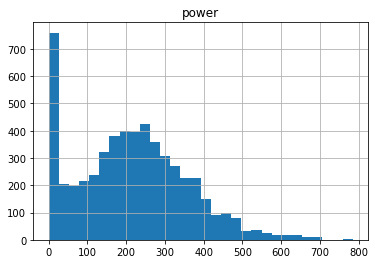

In [20]:
# test if 785 Watt can be detected as an outlier visually

rr19_power_distribution = rr19.hist('power', bins=30, histtype='stepfilled')

After clarification about usual values for power generation of cyclists, the maximum value for power will not be removed and kept as it is. It is supposed to be a realistic value.

In [21]:
# show relevant features

rr19_distance = rr19["distance"].sum()
rr19_time = rr19["timedelta"].sum()/60
rr19_elevation = rr19["elevation_gain"].sum()
rr19_speed = rr19["speed"].mean()
rr19_minkm = (rr19_time)/rr19_distance

print("Total distance travelled for road race in 2019 is:\t", round(rr19_distance, 2), "km")
print("Total time needed for road race in 2019 is:\t\t", round(rr19_time, 2), "minutes")
print("Total elevation gain for road race in 2019 is:\t\t", round(rr19_elevation, 2), "m")
print("The mean speed for road race in 2019 is:\t\t", round(rr19_speed, 2), "km/h")
print("The mean time per kilometer for road race in 2019 is:\t", round(rr19_minkm, 2), "min/km")

Total distance travelled for road race in 2019 is:	 51.79 km
Total time needed for road race in 2019 is:		 91.7 minutes
Total elevation gain for road race in 2019 is:		 1.4 m
The mean speed for road race in 2019 is:		 33.88 km/h
The mean time per kilometer for road race in 2019 is:	 1.77 min/km


In [22]:
# add simple moving average of speed as a column 

rr19["speed_SMA"] = rr19["speed"].rolling(window=60, # considers 60 observations per calculation; appr. one calculation per km
                         min_periods=1).mean()
rr19.head()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,speed_SMA
2019-06-22 22:33:45+00:00,-33.416592,151.222853,215.0,0.0,0.0,58.0,71.0,0.000000,0.0,0.000000,0.0,0.000000
2019-06-22 22:33:46+00:00,-33.416629,151.222877,215.0,0.0,147.0,58.0,71.0,0.004679,0.0,16.842677,1.0,8.421339
2019-06-22 22:33:47+00:00,-33.416677,151.222905,214.8,0.0,97.0,60.0,71.0,0.005936,-0.2,21.371074,1.0,12.737917
2019-06-22 22:33:48+00:00,-33.416730,151.222937,214.8,0.0,74.0,61.0,71.0,0.006599,0.0,23.757913,1.0,15.492916
2019-06-22 22:33:49+00:00,-33.416783,151.222972,214.8,0.0,136.0,62.0,71.0,0.006729,0.0,24.225566,1.0,17.239446


#### 2.3 Time Trial 2016

In [23]:
# overall statistical summary for time trial one in 2016

tt16.describe()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
count,1541.000000,1541.000000,1541.000000,1541.000000,1541.0,1541.000000,1541.000000,1541.000000,1541.000000,1541.000000,1540.000000
mean,-33.368105,151.225411,139.068657,10.953277,0.0,83.277093,170.939650,0.016095,-0.002466,33.529963,1.783766
std,0.028055,0.006166,30.301132,0.657937,0.0,21.169978,23.392548,0.015897,0.515343,11.519681,1.822713
min,-33.418368,151.211206,85.000000,10.000000,0.0,0.000000,100.000000,0.000000,-7.400000,0.000000,1.000000
25%,-33.393795,151.221870,116.200000,11.000000,0.0,77.000000,157.000000,0.007622,-0.400000,25.068271,1.000000
50%,-33.370613,151.227333,134.000000,11.000000,0.0,86.000000,161.000000,0.010974,0.000000,32.840076,1.000000
75%,-33.343332,151.230072,165.400000,11.000000,0.0,96.000000,180.000000,0.015960,0.400000,41.470522,2.000000
max,-33.316888,151.235137,202.600000,13.000000,0.0,118.000000,251.000000,0.288175,2.400000,162.505764,31.000000


Note the following:<br/>
- maximum recorded speed is 162 km/h. As discussed before, this value is unrealistic and will be replaced.
- maximum recorded heart rate is 251 bpm. This requires further investigation since it seems like an impossible value. The assumption is that a maximum heart rate is 220 minus age which in this case is assumed to be 50. This relates to a maximum heart rate of 170. After allowing for some peak exceptions, all bpm values over 180 will be treated as outliers. They will be replaced with the median value. This metric is used since the distribution is skewed to the right, thus, the median will provide a better proxy for the center of the distribution.

In [24]:
# check for null values

tt16[tt16.isna().any(axis=1)]

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
2016-07-02 23:05:30+00:00,-33.415971,151.222016,111.8,12.0,0.0,58.0,108.0,0.0,0.0,0.0,NaN


In [25]:
# fill timedelta with 0

tt16["timedelta"] = tt16["timedelta"].fillna(0)
tt16[tt16.isna().any(axis=1)]

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta


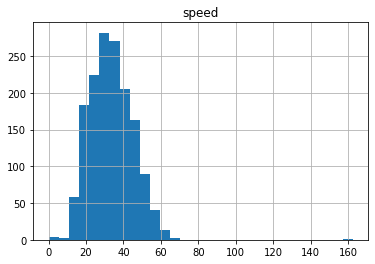

In [26]:
# test if 162km/h can be detected visually as an outlier

tt16_speed_distribution = tt16.hist('speed', bins=30, histtype='stepfilled')

<AxesSubplot:>

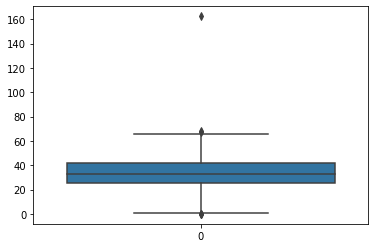

In [27]:
sns.boxplot(data=tt16["speed"])

In [28]:
# replace values over 70

tt16["speed2"] = np.where(tt16["speed"] > 70, 70, tt16["speed"])
tt16_clean = tt16.drop('speed', 1)
tt16_clean.rename(columns={'speed2': 'speed'}, inplace=True)

tt16_clean.describe()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,timedelta,speed
count,1541.000000,1541.000000,1541.000000,1541.000000,1541.0,1541.000000,1541.000000,1541.000000,1541.000000,1541.000000,1541.000000
mean,-33.368105,151.225411,139.068657,10.953277,0.0,83.277093,170.939650,0.016095,-0.002466,1.782609,33.469933
std,0.028055,0.006166,30.301132,0.657937,0.0,21.169978,23.392548,0.015897,0.515343,1.822688,11.079771
min,-33.418368,151.211206,85.000000,10.000000,0.0,0.000000,100.000000,0.000000,-7.400000,0.000000,0.000000
25%,-33.393795,151.221870,116.200000,11.000000,0.0,77.000000,157.000000,0.007622,-0.400000,1.000000,25.068271
50%,-33.370613,151.227333,134.000000,11.000000,0.0,86.000000,161.000000,0.010974,0.000000,1.000000,32.840076
75%,-33.343332,151.230072,165.400000,11.000000,0.0,96.000000,180.000000,0.015960,0.400000,2.000000,41.470522
max,-33.316888,151.235137,202.600000,13.000000,0.0,118.000000,251.000000,0.288175,2.400000,31.000000,70.000000


<AxesSubplot:>

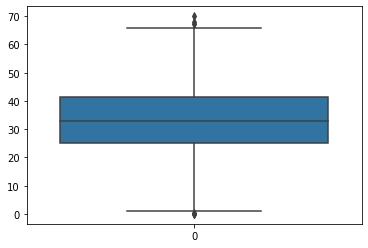

In [29]:
# verify replacement with boxplot
sns.boxplot(data=tt16_clean["speed"])

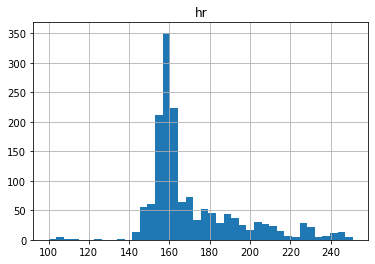

In [30]:
# test if 251 bpm can be detected visually as an outlier

tt16_bpm_distribution = tt16_clean.hist('hr', bins=40, histtype='stepfilled')

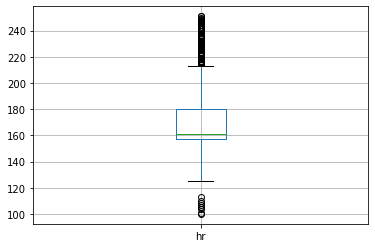

In [31]:
tt16_bpm_boxplot = tt16_clean.boxplot('hr')

In [32]:
# replace values over 180

tt16_hrmean = tt16_clean.drop(index = tt16_clean.index[tt16_clean["hr"] > 180])
tt16_hrmean = tt16_hrmean["hr"].mean()

tt16_clean["hr"] = np.where(tt16_clean["hr"] > 180, tt16_hrmean, tt16_clean["hr"])

tt16_clean.describe()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,timedelta,speed
count,1541.000000,1541.000000,1541.000000,1541.000000,1541.0,1541.000000,1541.000000,1541.000000,1541.000000,1541.000000,1541.000000
mean,-33.368105,151.225411,139.068657,10.953277,0.0,83.277093,159.649829,0.016095,-0.002466,1.782609,33.469933
std,0.028055,0.006166,30.301132,0.657937,0.0,21.169978,7.743442,0.015897,0.515343,1.822688,11.079771
min,-33.418368,151.211206,85.000000,10.000000,0.0,0.000000,100.000000,0.000000,-7.400000,0.000000,0.000000
25%,-33.393795,151.221870,116.200000,11.000000,0.0,77.000000,157.000000,0.007622,-0.400000,1.000000,25.068271
50%,-33.370613,151.227333,134.000000,11.000000,0.0,86.000000,159.649829,0.010974,0.000000,1.000000,32.840076
75%,-33.343332,151.230072,165.400000,11.000000,0.0,96.000000,162.000000,0.015960,0.400000,2.000000,41.470522
max,-33.316888,151.235137,202.600000,13.000000,0.0,118.000000,180.000000,0.288175,2.400000,31.000000,70.000000


array([[<AxesSubplot:title={'center':'hr'}>]], dtype=object)

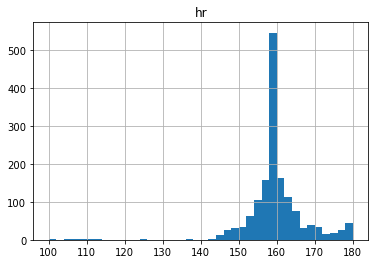

In [33]:
# show new distribution 

tt16_clean.hist('hr', bins=40, histtype='stepfilled')

<AxesSubplot:>

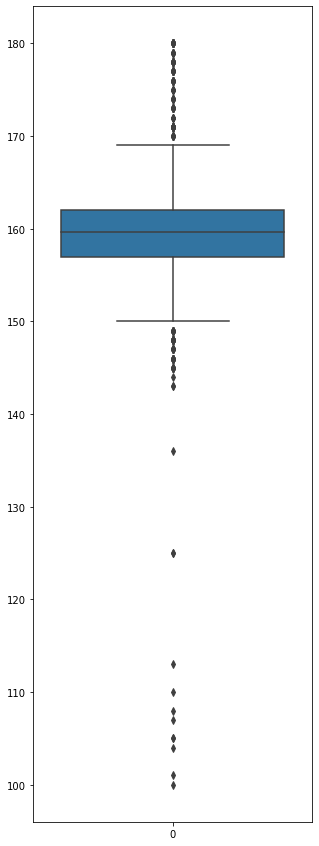

In [34]:
# show new boxplot
plt.figure(figsize=(5, 15))
sns.boxplot(data=tt16_clean['hr'])

Note: Even though there are a lot of outliers in the bottom range, these will be treated as regular values since these heart rates are realistic for relaxation phases or the start of the race.

In [35]:
# show relevant features

tt16_clean_distance = tt16_clean["distance"].sum()
tt16_clean_time = tt16_clean["timedelta"].sum()/60
tt16_clean_elevation = tt16_clean["elevation_gain"].sum()
tt16_clean_speed = tt16_clean["speed"].mean()
tt16_clean_minkm = (tt16_clean_time)/tt16_clean_distance

print("Total distance travelled for time trial in 2016 is:\t", round(tt16_clean_distance, 2), "km")
print("Total time needed for time trial in 2016 is:\t\t", round(tt16_clean_time, 2), "minutes")
print("Total elevation gain for time trial in 2016 is:\t\t", round(tt16_clean_elevation, 2), "m")
print("The mean speed for time trial in 2016 is:\t\t", round(tt16_clean_speed, 2), "km/h")
print("The mean time per kilometer for time trial in 2016 is:\t", round(tt16_clean_minkm, 2), "min/km")

Total distance travelled for time trial in 2016 is:	 24.8 km
Total time needed for time trial in 2016 is:		 45.78 minutes
Total elevation gain for time trial in 2016 is:		 -3.8 m
The mean speed for time trial in 2016 is:		 33.47 km/h
The mean time per kilometer for time trial in 2016 is:	 1.85 min/km


In [36]:
# add simple moving average of speed as a column 

tt16_clean["speed_SMA"] = tt16_clean["speed"].rolling(window=60, # considers 60 observations per calculation; appr. one calculation per km
                         min_periods=1).mean()
tt16_clean.head()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,timedelta,speed,speed_SMA
2016-07-02 23:05:30+00:00,-33.415971,151.222016,111.8,12.0,0.0,58.0,108.0,0.000000,0.0,0.0,0.000000,0.000000
2016-07-02 23:05:32+00:00,-33.416026,151.222008,111.8,12.0,0.0,58.0,105.0,0.006161,0.0,2.0,11.089134,5.544567
2016-07-02 23:05:38+00:00,-33.416034,151.222023,111.8,12.0,0.0,58.0,105.0,0.001652,0.0,6.0,0.991282,4.026805
2016-07-02 23:06:01+00:00,-33.416041,151.222038,111.8,13.0,0.0,58.0,100.0,0.001595,0.0,23.0,0.249655,3.082518
2016-07-02 23:06:02+00:00,-33.416048,151.222053,111.8,13.0,0.0,65.0,101.0,0.001595,0.0,1.0,5.742071,3.614428


#### 2.3 Time Trial 2019

In [37]:
# overall statistical summary for time trial two in 2019

tt19.describe()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
count,2655.000000,2655.000000,2655.000000,2655.000000,2655.000000,2655.000000,2655.000000,2655.000000,2655.000000,2655.000000,2654.0
mean,-33.368391,151.225397,250.435104,10.194350,257.566855,89.979661,152.741243,0.009183,0.000377,33.057824,1.0
std,0.028682,0.006234,29.434104,0.833934,80.023555,17.543883,8.217632,0.002715,0.298628,9.773522,0.0
min,-33.415798,151.211507,195.800000,9.000000,0.000000,0.000000,88.000000,0.000000,-1.600000,0.000000,1.0
25%,-33.394910,151.221400,229.200000,10.000000,213.500000,88.000000,150.000000,0.007345,-0.200000,26.440757,1.0
50%,-33.370118,151.227363,243.800000,10.000000,264.000000,94.000000,153.000000,0.009228,0.000000,33.220108,1.0
75%,-33.343803,151.230040,276.200000,10.000000,308.000000,98.000000,158.000000,0.010913,0.200000,39.286242,1.0
max,-33.316882,151.235098,312.200000,13.000000,522.000000,111.000000,166.000000,0.017584,0.600000,63.300734,1.0


In [38]:
# check for missing values

tt19[tt19.isna().any(axis=1)]

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
2019-06-01 22:54:55+00:00,-33.415798,151.22206,219.4,13.0,0.0,0.0,88.0,0.0,0.0,0.0,NaN


In [39]:
# fill timedelta with 0

tt19["timedelta"] = tt19["timedelta"].fillna(0)
tt19[tt19.isna().any(axis=1)]

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta


In [40]:
# show relevant features

tt19_distance = tt19["distance"].sum()
tt19_time = tt19["timedelta"].sum()/60
tt19_elevation = tt19["elevation_gain"].sum()
tt19_speed = tt19["speed"].mean()
tt19_minkm = (tt19_time)/tt19_distance

print("Total distance travelled for time trial in 2019 is:\t", round(tt19_distance, 2), "km")
print("Total time needed for time trial in 2019 is:\t\t", round(tt19_time, 2), "minutes")
print("Total elevation gain for time trial in 2019 is:\t\t", round(tt19_elevation, 2), "m")
print("The mean speed for time trial in 2019 is:\t\t", round(tt19_speed, 2), "km/h")
print("The mean time per kilometer for time trial in 2019 is:\t", round(tt19_minkm, 2), "min/km")

Total distance travelled for time trial in 2019 is:	 24.38 km
Total time needed for time trial in 2019 is:		 44.23 minutes
Total elevation gain for time trial in 2019 is:		 1.0 m
The mean speed for time trial in 2019 is:		 33.06 km/h
The mean time per kilometer for time trial in 2019 is:	 1.81 min/km


In [41]:
# add simple moving average of speed as a column 

tt19["speed_SMA"] = tt19["speed"].rolling(window=60, # considers 60 observations per calculation; appr. one calculation per km
                         min_periods=1).mean()
tt19.head()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,speed_SMA
2019-06-01 22:54:55+00:00,-33.415798,151.222060,219.4,13.0,0.0,0.0,88.0,0.000000,0.0,0.000000,0.0,0.000000
2019-06-01 22:54:56+00:00,-33.415782,151.222051,219.4,13.0,0.0,0.0,88.0,0.001965,0.0,7.075656,1.0,3.537828
2019-06-01 22:54:57+00:00,-33.415767,151.222041,219.4,13.0,0.0,0.0,88.0,0.001909,0.0,6.871582,1.0,4.649079
2019-06-01 22:54:58+00:00,-33.415751,151.222032,219.4,13.0,0.0,0.0,89.0,0.001965,0.0,7.075656,1.0,5.255724
2019-06-01 22:54:59+00:00,-33.415735,151.222022,219.4,13.0,0.0,0.0,89.0,0.002007,0.0,7.223997,1.0,5.649378


In [42]:
# comparison of all race metrics

comparison = pd.DataFrame(
    {
        'Race':['rr16_clean', 'rr19', 'tt16_clean', 'tt19'],
        'Total_Distance':[rr16_clean_distance, rr19_distance, tt16_clean_distance, tt19_distance],
        'Total_Time':[rr16_clean_time, rr19_time, tt16_clean_time, tt19_time],
        'Total_Elevation':[rr16_clean_elevation, rr19_elevation, tt16_clean_elevation, tt19_elevation],
        'Mean_Speed':[rr16_clean_speed, rr19_speed, tt16_clean_speed, tt19_speed],
        'Min_Km':[rr16_clean_minkm, rr19_minkm, tt16_clean_minkm, tt19_minkm]
    })
comparison

,Race,Total_Distance,Total_Time,Total_Elevation,Mean_Speed,Min_Km
0,rr16_clean,49.048586,86.666667,-10.6,34.917899,1.766955
1,rr19,51.789133,91.700000,1.4,33.879861,1.770642
2,tt16_clean,24.802887,45.783333,-3.8,33.469933,1.845887
3,tt19,24.380145,44.233333,1.0,33.057824,1.814318


#### Part One Summary
As expected, the total distance and time of road races are approximately double the amount compared to time trials. However, it is interesting to see that the average speed is not significantly different among the races. One could expect the shorter races to have an higher average speed. On the contrary, the average time per kilometer is even longer for the time trial races which is a bit surprising.

### 3. Compare the range of speeds for each ride, are time trials faster than road races?

In [43]:
speed_comparison = pd.DataFrame({
    'Speed Statistics':['Mean', 'Median', 'Std. Deviation', 'Maximum'],
    'rr16_clean':[rr16_clean["speed"].mean(), rr16_clean["speed"].median(), rr16_clean["speed"].std(), rr16_clean["speed"].max()],
    'rr19':[rr19["speed"].mean(), rr19["speed"].median(), rr19["speed"].std(), rr19["speed"].max()],
    'tt16_clean':[tt16_clean["speed"].mean(), tt16_clean["speed"].median(), tt16_clean["speed"].std(), tt16_clean["speed"].max()],
    'tt19':[tt19["speed"].mean(), tt19["speed"].median(), tt19["speed"].std(), tt19["speed"].max()]
    })
speed_comparison

,Speed Statistics,rr16_clean,rr19,tt16_clean,tt19
0,Mean,34.917899,33.879861,33.469933,33.057824
1,Median,33.307339,33.041360,32.840076,33.220108
2,Std. Deviation,10.674109,8.853503,11.079771,9.773522
3,Maximum,70.000000,70.370469,70.000000,63.300734


### Part Two Summary
As has already been shown in part one, time trials are not faster than road races. Rather on the contrary, both road races were faster on average than time trials. It is also interesting to see that the variance around the mean is higher for both races in 2016. This indicates that both races in 2019 were performed with a higher consistency of speed. 

### 4. Compare the speeds achieved in the two time trials (three years apart). As well as looking at the averages, can you see where in the ride one or the other is faster.

In [44]:
tt_speed_comparison = pd.DataFrame({
    'Speed Statistics':['Mean', 'Median', 'Std. Deviation', 'Maximum'],
    'tt16_clean':[tt16_clean["speed"].mean(), tt16_clean["speed"].median(), tt16_clean["speed"].std(), tt16_clean["speed"].max()],
    'tt19':[tt19["speed"].mean(), tt19["speed"].median(), tt19["speed"].std(), tt19["speed"].max()]
    })
tt_speed_comparison

,Speed Statistics,tt16_clean,tt19
0,Mean,33.469933,33.057824
1,Median,32.840076,33.220108
2,Std. Deviation,11.079771,9.773522
3,Maximum,70.000000,63.300734


In [45]:
# compare times
tt_time_comparison = pd.DataFrame({
    'tt16_clean':[tt16_clean_time],
    'tt19':[tt19_time]
    })
tt_time_comparison

,tt16_clean,tt19
0,45.783333,44.233333


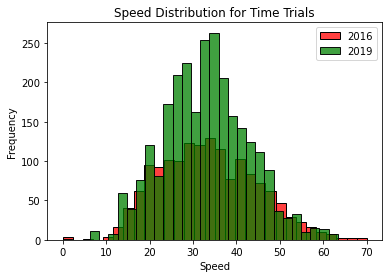

In [46]:
# show speed distribution to validate assumption that tt16 is faster and tt19 will have more low values for speed since median>mean

sns.histplot(data=tt16_clean["speed"], bins=30, color='red', label='2016')
sns.histplot(data=tt19["speed"], bins=30, color='green', label='2019')
plt.xlabel('Speed')
plt.ylabel('Frequency')
plt.title('Speed Distribution for Time Trials')
plt.legend(loc='upper right')
plt.show()

In [47]:
# calculate cumulative sum of racetime tt16
tt16_clean["racetime"] = tt16_clean["timedelta"].fillna(0).cumsum().div(60).astype(float)
tt16_clean.tail()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,timedelta,speed,speed_SMA,racetime
2016-07-02 23:50:39+00:00,-33.415476,151.221628,116.0,11.0,0.0,100.0,163.0,0.024989,0.0,2.0,44.980624,41.343518,45.150000
2016-07-02 23:50:41+00:00,-33.415667,151.221757,115.4,11.0,0.0,99.0,163.0,0.024381,-0.6,2.0,43.885165,41.620033,45.183333
2016-07-02 23:50:45+00:00,-33.416048,151.222013,115.4,11.0,0.0,0.0,162.0,0.048573,0.0,4.0,43.716017,41.871087,45.250000
2016-07-02 23:51:16+00:00,-33.418333,151.223478,108.0,11.0,0.0,64.0,143.0,0.288175,-7.4,31.0,33.465472,41.940232,45.766667
2016-07-02 23:51:17+00:00,-33.418368,151.223494,108.0,11.0,0.0,64.0,143.0,0.004166,0.0,1.0,14.995824,41.680051,45.783333


In [48]:
# calculate cumulative sum of racetime tt19
tt19["racetime"] = tt19["timedelta"].fillna(0).cumsum().div(60).astype(float)
tt19.tail()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,speed_SMA,racetime
2019-06-01 23:39:05+00:00,-33.415270,151.221994,220.8,10.0,335.0,101.0,166.0,0.012323,-0.2,44.363507,1.0,41.533530,44.166667
2019-06-01 23:39:06+00:00,-33.415367,151.222056,220.8,10.0,350.0,101.0,166.0,0.012225,0.0,44.009916,1.0,41.612904,44.183333
2019-06-01 23:39:07+00:00,-33.415462,151.222122,220.6,10.0,273.0,101.0,166.0,0.012211,-0.2,43.960218,1.0,41.691450,44.200000
2019-06-01 23:39:08+00:00,-33.415555,151.222189,220.4,10.0,210.0,99.0,166.0,0.012067,-0.2,43.440736,1.0,41.748817,44.216667
2019-06-01 23:39:09+00:00,-33.415648,151.222255,220.4,10.0,154.0,73.0,166.0,0.012019,0.0,43.269479,1.0,41.804219,44.233333


In [49]:
# calculate SMA with larger window (appr. 5km rolling average)
tt16_clean["speed_SMA_large"] = tt16_clean["speed"].rolling(window=300, 
                         min_periods=1).mean()
tt19["speed_SMA_large"] = tt19["speed"].rolling(window=300,
                         min_periods=1).mean()

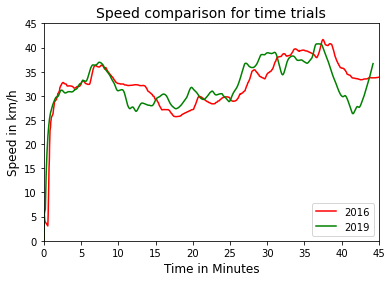

In [50]:
# show at which time of the two races speed was higher or lower
ax = sns.lineplot(data=tt16_clean, x="racetime", y="speed_SMA_large", color='red', label='2016')
sns.lineplot(data=tt19, x="racetime", y="speed_SMA_large", color='green', label='2019', ax=ax)
plt.xlim(0, 45)
plt.ylim(0, 45)
plt.xlabel('Time in Minutes', fontsize=12)
plt.ylabel('Speed in km/h', fontsize=12)
plt.title('Speed comparison for time trials', fontsize=14)
plt.legend(loc='lower right')

In [51]:
comparison2 = pd.DataFrame(
    {
        'Race':['tt16_clean', 'tt19'],
        'Total_Distance':[tt16_clean_distance, tt19_distance],
        'Total_Time':[tt16_clean_time, tt19_time],
        'Mean_Speed':[tt16_clean_speed, tt19_speed],
        'Min_Km':[tt16_clean_minkm, tt19_minkm]
    })
comparison2

,Race,Total_Distance,Total_Time,Mean_Speed,Min_Km
0,tt16_clean,24.802887,45.783333,33.469933,1.845887
1,tt19,24.380145,44.233333,33.057824,1.814318


### Part Three Summary
As has been shown before, the time trial in 2016 was slightly faster on average than the time trial in 2019. However, even though it was faster on average, it took longer to finish. This is partially due to a slightly longer distance, but even adjusted for distance it took longer as can be seen in the Min_Km column which calculates the pace per kilometer. <br />
In the plot where speed has been shown over racetime, it can be seen that both races were very similar. From the start, the rider had almost identical speed while in the 5 minutes after he was significantly faster in 2016. From minute 15-30, the difference is small but always slightly faster in 2019. That switches for the subsequent 15 minutes even though the acceleration to the end of time trial 2019 was higher.

In [52]:
# calculate racetime for both road races too for consistency

rr16_clean["racetime"] = rr16_clean["timedelta"].fillna(0).cumsum().div(60).astype(float)
rr16_clean.tail()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,timedelta,speed,speed_SMA,racetime
2016-05-14 05:29:16+00:00,-33.416432,151.222722,198.4,24.0,0.0,0.0,172.0,0.008624,0.0,1.0,31.045284,41.344776,86.583333
2016-05-14 05:29:17+00:00,-33.416497,151.222764,198.4,24.0,0.0,0.0,168.0,0.008212,0.0,1.0,29.562739,41.125605,86.600000
2016-05-14 05:29:18+00:00,-33.416563,151.222807,198.4,24.0,0.0,0.0,164.0,0.008354,0.0,1.0,30.073849,40.880928,86.616667
2016-05-14 05:29:19+00:00,-33.416627,151.222852,198.4,24.0,0.0,0.0,161.0,0.008252,0.0,1.0,29.705591,40.622831,86.633333
2016-05-14 05:29:21+00:00,-33.416753,151.222934,198.0,24.0,0.0,0.0,158.0,0.015944,-0.4,2.0,28.699591,40.356455,86.666667


In [53]:
rr19["racetime"] = rr19["timedelta"].fillna(0).cumsum().div(60).astype(float)
rr19.tail()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,speed_SMA,racetime
2019-06-23 00:05:23+00:00,-33.415728,151.222289,216.6,7.0,28.0,23.0,153.0,0.010218,-0.2,36.786246,1.0,39.222828,91.633333
2019-06-23 00:05:24+00:00,-33.415808,151.222340,216.6,7.0,13.0,10.0,153.0,0.010077,0.0,36.275739,1.0,39.186784,91.650000
2019-06-23 00:05:25+00:00,-33.415885,151.222391,216.6,7.0,0.0,0.0,152.0,0.009783,0.0,35.220093,1.0,39.128336,91.666667
2019-06-23 00:05:26+00:00,-33.415962,151.222440,216.6,7.0,0.0,0.0,152.0,0.009695,0.0,34.901660,1.0,39.084679,91.683333
2019-06-23 00:05:27+00:00,-33.416037,151.222489,216.4,7.0,0.0,0.0,151.0,0.009499,-0.2,34.196667,1.0,39.016811,91.700000


## 5. From the elevation_gain field you can see whether the rider is climbing , descending or on the flat. Use this to calculate the average speeds in those three cases (climbing, flat or descending). Note that flat might not be zero elevation_gain but might allow for slight climbs and falls.

Dataframes are named as follows:
- tt16_clean
- tt19
- rr16_clean
- rr19

In [54]:
# select a few random rows

tt16_clean.sample(10)

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,timedelta,speed,speed_SMA,racetime,speed_SMA_large
2016-07-02 23:21:26+00:00,-33.354396,151.228504,150.0,11.0,0.0,85.0,153.000000,0.024743,0.4,3.0,29.691383,30.004909,15.933333,27.116142
2016-07-02 23:33:05+00:00,-33.330727,151.231302,175.8,10.0,0.0,99.0,159.649829,0.014011,-0.6,1.0,50.438019,42.602914,27.583333,33.215186
2016-07-02 23:13:24+00:00,-33.385038,151.224103,87.0,11.0,0.0,72.0,159.649829,0.007693,0.4,1.0,27.693531,39.422566,7.900000,36.255188
2016-07-02 23:40:49+00:00,-33.372958,151.227869,134.2,11.0,0.0,86.0,156.000000,0.010881,0.0,1.0,39.171749,41.496142,35.316667,39.275490
2016-07-02 23:27:57+00:00,-33.327040,151.231312,185.4,11.0,0.0,86.0,163.000000,0.035703,0.4,5.0,25.706422,25.090204,22.450000,28.449747
2016-07-02 23:35:51+00:00,-33.345792,151.229815,168.6,10.0,0.0,83.0,153.000000,0.009708,0.4,1.0,34.948200,35.293910,30.350000,34.982750
2016-07-02 23:36:03+00:00,-33.346838,151.229948,169.0,10.0,0.0,86.0,157.000000,0.030631,0.0,3.0,36.756789,35.641209,30.550000,35.151379
2016-07-02 23:42:51+00:00,-33.386031,151.224334,88.2,11.0,0.0,0.0,159.649829,0.016607,-1.0,1.0,59.785282,49.766426,37.350000,41.248504
2016-07-02 23:46:41+00:00,-33.395642,151.216021,129.2,11.0,0.0,100.0,160.000000,0.010302,-0.4,1.0,37.086743,17.279303,41.183333,34.199270
2016-07-02 23:28:00+00:00,-33.326852,151.231327,187.0,11.0,0.0,86.0,163.000000,0.007138,0.4,1.0,25.697791,24.392113,22.500000,28.384740


To evaluate what is flat or not, it is necessary to know the gradient of the road for each record. This can be roughly calculated by dividing the elevation gain by the distance. This implies that, first, a new column needs to be calculated that transforms the distance to meters and, second, another column where the gradient is calculated.<br >
Based on some research, gradients of 1-3% are still considered rather flat than climbing or descending. Thus, the following assumption is made to classify:
- Descending: < -3%
- Flat: >= -3% & <= 3%
- Climbing: > 3%

In [55]:
# new column where distance is transformed to meters for tt16

tt16_clean["distance_m"] = tt16_clean["distance"].apply(lambda x: x*1000)
tt16_clean.head()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,timedelta,speed,speed_SMA,racetime,speed_SMA_large,distance_m
2016-07-02 23:05:30+00:00,-33.415971,151.222016,111.8,12.0,0.0,58.0,108.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2016-07-02 23:05:32+00:00,-33.416026,151.222008,111.8,12.0,0.0,58.0,105.0,0.006161,0.0,2.0,11.089134,5.544567,0.033333,5.544567,6.160630
2016-07-02 23:05:38+00:00,-33.416034,151.222023,111.8,12.0,0.0,58.0,105.0,0.001652,0.0,6.0,0.991282,4.026805,0.133333,4.026805,1.652136
2016-07-02 23:06:01+00:00,-33.416041,151.222038,111.8,13.0,0.0,58.0,100.0,0.001595,0.0,23.0,0.249655,3.082518,0.516667,3.082518,1.595020
2016-07-02 23:06:02+00:00,-33.416048,151.222053,111.8,13.0,0.0,65.0,101.0,0.001595,0.0,1.0,5.742071,3.614428,0.533333,3.614428,1.595020


In [56]:
# new column where distance is transformed to meters for tt19

tt19["distance_m"] = tt19["distance"].apply(lambda x: x*1000)
tt19.head()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,speed_SMA,racetime,speed_SMA_large,distance_m
2019-06-01 22:54:55+00:00,-33.415798,151.222060,219.4,13.0,0.0,0.0,88.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2019-06-01 22:54:56+00:00,-33.415782,151.222051,219.4,13.0,0.0,0.0,88.0,0.001965,0.0,7.075656,1.0,3.537828,0.016667,3.537828,1.965460
2019-06-01 22:54:57+00:00,-33.415767,151.222041,219.4,13.0,0.0,0.0,88.0,0.001909,0.0,6.871582,1.0,4.649079,0.033333,4.649079,1.908773
2019-06-01 22:54:58+00:00,-33.415751,151.222032,219.4,13.0,0.0,0.0,89.0,0.001965,0.0,7.075656,1.0,5.255724,0.050000,5.255724,1.965460
2019-06-01 22:54:59+00:00,-33.415735,151.222022,219.4,13.0,0.0,0.0,89.0,0.002007,0.0,7.223997,1.0,5.649378,0.066667,5.649378,2.006666


In [57]:
# new column where distance is transformed to meters for rr16

rr16_clean["distance_m"] = rr16_clean["distance"].apply(lambda x: x*1000)
rr16_clean.head()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,timedelta,speed,speed_SMA,racetime,distance_m
2016-05-14 04:02:41+00:00,-33.415561,151.222303,208.6,29.0,0.0,40.0,102.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2016-05-14 04:02:42+00:00,-33.415534,151.222289,208.6,29.0,0.0,40.0,102.0,0.003271,0.0,1.0,11.777020,5.888510,0.016667,3.271394
2016-05-14 04:02:46+00:00,-33.415398,151.222180,208.6,29.0,0.0,40.0,103.0,0.018194,0.0,4.0,16.375033,9.384018,0.083333,18.194482
2016-05-14 04:02:49+00:00,-33.415264,151.222077,208.6,29.0,0.0,55.0,106.0,0.017703,0.0,3.0,21.243901,12.348989,0.133333,17.703250
2016-05-14 04:02:51+00:00,-33.415160,151.222013,208.6,29.0,0.0,61.0,109.0,0.013001,0.0,2.0,23.401217,14.559434,0.166667,13.000676


In [58]:
# new column where distance is transformed to meters for rr19

rr19["distance_m"] = rr19["distance"].apply(lambda x: x*1000)
rr19.head()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,speed_SMA,racetime,distance_m
2019-06-22 22:33:45+00:00,-33.416592,151.222853,215.0,0.0,0.0,58.0,71.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
2019-06-22 22:33:46+00:00,-33.416629,151.222877,215.0,0.0,147.0,58.0,71.0,0.004679,0.0,16.842677,1.0,8.421339,0.016667,4.678521
2019-06-22 22:33:47+00:00,-33.416677,151.222905,214.8,0.0,97.0,60.0,71.0,0.005936,-0.2,21.371074,1.0,12.737917,0.033333,5.936409
2019-06-22 22:33:48+00:00,-33.416730,151.222937,214.8,0.0,74.0,61.0,71.0,0.006599,0.0,23.757913,1.0,15.492916,0.050000,6.599420
2019-06-22 22:33:49+00:00,-33.416783,151.222972,214.8,0.0,136.0,62.0,71.0,0.006729,0.0,24.225566,1.0,17.239446,0.066667,6.729324


In [59]:
# new column where gradient is calculated for tt16

tt16_clean["gradient"] = round((tt16_clean["elevation_gain"] / tt16_clean["distance_m"] * 100), 1)
tt16_clean["gradient"].describe()

count    1539.000000
mean        1.236517
std         5.110887
min       -11.400000
25%        -3.000000
50%         0.000000
75%         5.400000
max        22.100000
Name: gradient, dtype: float64

In [60]:
# check for null values

tt16_clean[tt16_clean["gradient"].isnull()]

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,timedelta,speed,speed_SMA,racetime,speed_SMA_large,distance_m,gradient
2016-07-02 23:05:30+00:00,-33.415971,151.222016,111.8,12.0,0.0,58.0,108.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,NaN
2016-07-02 23:31:55+00:00,-33.323696,151.232612,186.8,10.0,0.0,86.0,178.0,0.0,0.0,3.0,0.0,35.746959,26.416667,30.308761,0.0,NaN


In [61]:
# new column where gradient is calculated for tt19

tt19["gradient"] = round((tt19["elevation_gain"] / tt19["distance_m"] * 100), 1)
tt19["gradient"].describe()

count    2654.000000
mean        0.791824
std         3.348575
min       -10.200000
25%        -1.700000
50%         0.000000
75%         2.700000
max        11.900000
Name: gradient, dtype: float64

In [62]:
# check for null values

tt19[tt19["gradient"].isnull()]

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,speed_SMA,racetime,speed_SMA_large,distance_m,gradient
2019-06-01 22:54:55+00:00,-33.415798,151.22206,219.4,13.0,0.0,0.0,88.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [63]:
# new column where gradient is calculated for rr16

rr16_clean["gradient"] = round((rr16_clean["elevation_gain"] / rr16_clean["distance_m"] * 100), 1)
rr16_clean["gradient"].describe()

count    2820.000
mean         -inf
std           NaN
min          -inf
25%        -3.200
50%         0.000
75%         5.225
max        14.200
Name: gradient, dtype: float64

In [64]:
# check for null values

rr16_clean[rr16_clean["gradient"].isnull()]

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,timedelta,speed,speed_SMA,racetime,distance_m,gradient
2016-05-14 04:02:41+00:00,-33.415561,151.222303,208.6,29.0,0.0,40.0,102.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,NaN
2016-05-14 04:18:20+00:00,-33.350502,151.229872,248.0,27.0,0.0,76.0,150.0,0.0,0.0,2.0,0.0,31.609848,15.65,0.0,NaN


In [65]:
rr16_clean[rr16_clean["gradient"] < -15]

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,timedelta,speed,speed_SMA,racetime,distance_m,gradient
2016-05-14 04:41:09+00:00,-33.395848,151.215595,218.4,25.0,0.0,83.0,171.0,0.0,-0.4,1.0,0.0,24.117325,38.466667,0.0,-inf


In [66]:
# new column where gradient is calculated for rr19

rr19["gradient"] = round((rr19["elevation_gain"] / rr19["distance_m"] * 100), 1)
rr19["gradient"].describe()

count    5502.000000
mean        0.644802
std         3.542312
min       -11.600000
25%        -1.900000
50%         0.000000
75%         2.600000
max        14.800000
Name: gradient, dtype: float64

In [67]:
# check for null values

rr19[rr19["gradient"].isnull()]

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,speed_SMA,racetime,distance_m,gradient
2019-06-22 22:33:45+00:00,-33.416592,151.222853,215.0,0.0,0.0,58.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


There are several null values for gradient. This happens if the distance value for the respective record is zero. It is weird, however, that only for one single value out of these, the value for gradient goes to infinity. This would be expected for all calculations where the denominator is zero. <br >
Most of these records are the first of each dataset which makes sense since there is previous record where the distance could have been calculated as a difference from. However, there are also values that originate from during the race. What all these records have in common is that they all have a speed of zero, thus, they seem rather like an error. To use gradient in the subsequent grouping, the records with distance equal to zero will be removed.

In [68]:
# remove null values for tt16

tt16_clean = tt16_clean.drop(index = tt16_clean.index[tt16_clean["distance_m"] == 0])
tt16_clean[tt16_clean["gradient"].isnull()]

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,timedelta,speed,speed_SMA,racetime,speed_SMA_large,distance_m,gradient


In [69]:
# remove null values for tt19

tt19 = tt19.drop(index = tt19.index[tt19["distance_m"] == 0])
tt19[tt19["gradient"].isnull()]

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,speed_SMA,racetime,speed_SMA_large,distance_m,gradient


In [70]:
# remove null values for rr16

rr16_clean = rr16_clean.drop(index = rr16_clean.index[rr16_clean["distance_m"] == 0])
rr16_clean[rr16_clean["gradient"].isnull()]

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,timedelta,speed,speed_SMA,racetime,distance_m,gradient


In [71]:
# remove null values for rr19

rr19 = rr19.drop(index = rr19.index[rr19["distance_m"] == 0])
rr19[rr19["gradient"].isnull()]

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,speed_SMA,racetime,distance_m,gradient


Text(0, 0.5, 'Speed in km/h')

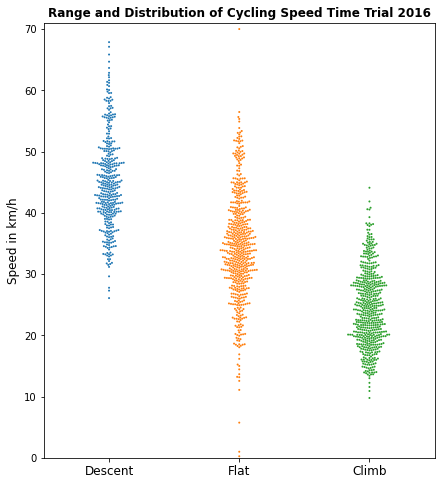

In [72]:
# create categories and plot speed for tt16

tt16_grad_cat = pd.cut(tt16_clean["gradient"], bins=[-100, -3, 3, 100], labels=['Descent', 'Flat', 'Climb'])
plt.figure(figsize=(7, 8))
sns.swarmplot(data=tt16_clean, x=tt16_grad_cat, y="speed", s=2)
plt.title('Range and Distribution of Cycling Speed Time Trial 2016', fontsize=12, fontweight="bold")
plt.ylim(0, 71)
plt.xlabel('')
plt.xticks(fontsize=12)
plt.ylabel('Speed in km/h', fontsize=12)

Text(0, 0.5, 'Speed in km/h')

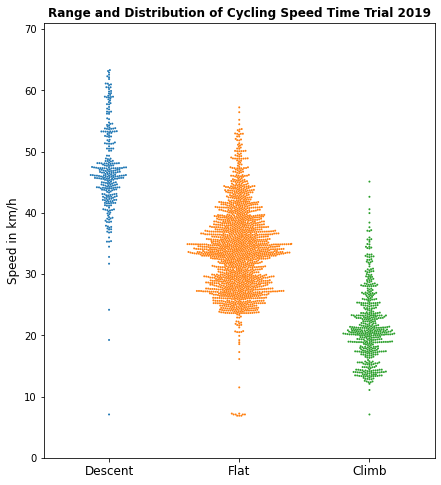

In [73]:
# create categories and plot speed for tt19

tt19_grad_cat = pd.cut(tt19["gradient"], bins=[-100, -3, 3, 100], labels=['Descent', 'Flat', 'Climb'])
plt.figure(figsize=(7, 8))
sns.swarmplot(data=tt19, x=tt19_grad_cat, y="speed", s=2)
plt.title('Range and Distribution of Cycling Speed Time Trial 2019', fontsize=12, fontweight="bold")
plt.ylim(0, 71)
plt.xlabel('')
plt.xticks(fontsize=12)
plt.ylabel('Speed in km/h', fontsize=12)

Text(0, 0.5, 'Speed in km/h')

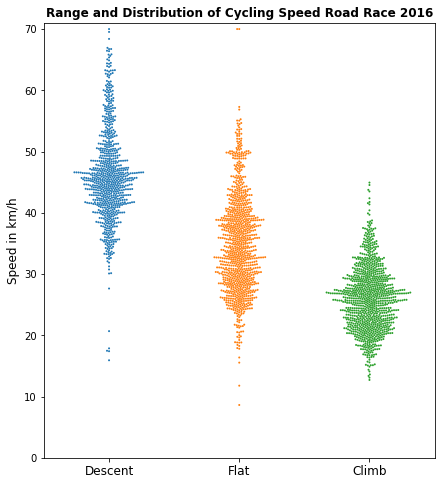

In [74]:
# create categories and plot speed for rr16

rr16_grad_cat = pd.cut(rr16_clean["gradient"], bins=[-100, -3, 3, 100], labels=['Descent', 'Flat', 'Climb'])
plt.figure(figsize=(7, 8))
sns.swarmplot(data=rr16_clean, x=rr16_grad_cat, y="speed", s=2)
plt.title('Range and Distribution of Cycling Speed Road Race 2016', fontsize=12, fontweight="bold")
plt.ylim(0, 71)
plt.xlabel('')
plt.xticks(fontsize=12)
plt.ylabel('Speed in km/h', fontsize=12)

/Users/felixrosenbergernew/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0, 0.5, 'Speed in km/h')

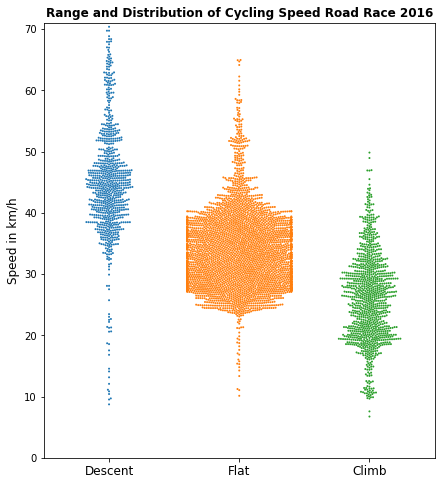

In [75]:
# create categories and plot speed for rr19

rr19_grad_cat = pd.cut(rr19["gradient"], bins=[-100, -3, 3, 100], labels=['Descent', 'Flat', 'Climb'])
plt.figure(figsize=(7, 8))
sns.swarmplot(data=rr19, x=rr19_grad_cat, y="speed", s=2)
plt.title('Range and Distribution of Cycling Speed Road Race 2016', fontsize=12, fontweight="bold")
plt.ylim(0, 71)
plt.xlabel('')
plt.xticks(fontsize=12)
plt.ylabel('Speed in km/h', fontsize=12)

As can already be seen from the above visualisations, speed tends be higher for descents, and lower for ascents which makes perfectly sense. The average speed for each group will be calculated in the following.

In [76]:
# calculate average speed per group for tt16

tt16_clean["gradient_category"] = tt16_grad_cat 

tt16_clean.groupby(["gradient_category"])[["speed", "racetime", "gradient"]].mean()


,speed,racetime,gradient
gradient_category,,,
Descent,45.070765,26.374746,-5.039848
Flat,34.373170,21.332538,-0.042760
Climb,24.448449,21.699612,7.013978


The average speed per category is approximately:
- Descent: 45 km/h
- Flat: 34 km/h
- Climb: 24km/h

It can also be seen that most of the racetime has been spent in descent with an average gradient of -5%. The average gradient for ascents was 7%.

In [77]:
# calculate average speed per group for tt19

tt19["gradient_category"] = tt19_grad_cat 

tt19.groupby(["gradient_category"])[["speed", "racetime", "gradient"]].mean()

,speed,racetime,gradient
gradient_category,,,
Descent,47.099371,25.173988,-4.340810
Flat,33.968360,21.957769,0.276693
Climb,21.541694,20.849341,5.642750


The average speed per category is approximately:
- Descent: 47 km/h
- Flat: 34 km/h
- Climb: 22 km/h

It can also be seen that most of the racetime has been spent in descent with an average gradient of -4%. The average gradient for ascents was 6%.

In [78]:
# calculate average speed per group for rr16

rr16_clean["gradient_category"] = rr16_grad_cat 

rr16_clean.groupby(["gradient_category"])[["speed", "racetime", "gradient"]].mean()

,speed,racetime,gradient
gradient_category,,,
Descent,46.064290,47.246518,-4.507787
Flat,34.971398,43.151287,-0.002207
Climb,26.066948,41.671224,6.314215


The average speed per category is approximately:
- Descent: 46 km/h
- Flat: 35 km/h
- Climb: 26 km/h

It can also be seen that most of the racetime has been spent in descent with an average gradient of -5%. The average gradient for ascents was 6%.

In [79]:
# calculate average speed per group for rr19

rr19["gradient_category"] = rr19_grad_cat 

rr19.groupby(["gradient_category"])[["speed", "racetime", "gradient"]].mean()

,speed,racetime,gradient
gradient_category,,,
Descent,44.816137,50.494947,-4.738386
Flat,33.722235,44.278052,0.355552
Climb,25.974680,47.699179,5.813649


The average speed per category is approximately:
- Descent: 45 km/h
- Flat: 34 km/h
- Climb: 26 km/h

It can also be seen that most of the racetime has been spent in descent with an average gradient of -5%. The average gradient for ascents was 6%.

### Part Four Summary

The average speed per category has been shown for each race above. What is interesting to see is that time trials and road races share similar speeds for each category except for ascents. Road races are 4-5km/h faster on average. It seems like drafting has the highest effect for this category.

## Challenge: Gear Usage

A modern race bike has up to 22 different gears with two chainrings on the front (attached to the pedals) and 10 or 11 at the back (attached to the wheel).   The ratio of the number of teeth on the front and rear cogs determines the distance travelled with one revolution of the pedals (often called __development__, measured in metres).  Low development is good for climbing hills while high development is for going fast downhill or in the final sprint. 

We have a measure of the number of rotations of the pedals per minute (__cadence__) and a measure of __speed__.  Using these two variables we should be able to derive a measure of __development__ which would effectivly tell us which gear the rider was using at the time.   Development will normally range between __2m__ and __10m__.  Due to errors in GPS and cadence measurements you will see many points outside this range and you should just discard them as outliers. 

Write code to calculate __development__ in _meters_ for each row in a ride.  Plot the result in a _histogram_ and compare the plots for the four rides.   Comment on what you observe in the histograms.





__Note:__ The approach to approximate the development per record is to first transform speed into meters per minute and then divide the result by the cadence.

### 1. Time Trial 2016

In [80]:
# create development column

tt16_clean["development"] = ((tt16_clean["speed"]*1000/60) / tt16_clean["cadence"])
tt16_clean.loc[: , ["cadence", "speed", "development"]].sample(10)

,cadence,speed,development
2016-07-02 23:21:27+00:00,84.0,28.671456,5.688781
2016-07-02 23:46:10+00:00,88.0,18.047765,3.418137
2016-07-02 23:16:15+00:00,89.0,24.777164,4.639918
2016-07-02 23:39:56+00:00,90.0,37.681790,6.978109
2016-07-02 23:43:47+00:00,71.0,47.603769,11.174594
2016-07-02 23:34:05+00:00,77.0,28.891492,6.253570
2016-07-02 23:11:46+00:00,29.0,56.808206,32.648394
2016-07-02 23:22:28+00:00,89.0,25.274369,4.733028
2016-07-02 23:44:03+00:00,78.0,37.430480,7.997966
2016-07-02 23:33:53+00:00,83.0,28.023117,5.627132


In [81]:
# check summary statistics 
tt16_clean["development"].describe()

count    1539.000000
mean             inf
std              NaN
min         0.071740
25%         5.165409
50%         6.162429
75%         7.341610
max              inf
Name: development, dtype: float64

In [82]:
# remove outliers and test if removed

tt16_clean = tt16_clean.drop(index = tt16_clean.index[((tt16_clean["development"] < 2) | (tt16_clean["development"] > 10))])
tt16_clean["development"].describe()


count    1452.000000
mean        6.105196
std         1.322145
min         2.625912
25%         5.071528
50%         6.048356
75%         7.122792
max         9.707783
Name: development, dtype: float64

<AxesSubplot:xlabel='development', ylabel='Count'>

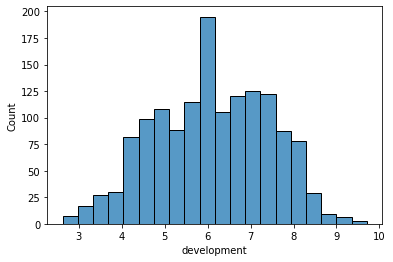

In [83]:
# show distribution

sns.histplot(data=tt16_clean, x="development", bins=20)

### 2. Time Trial 2019

In [84]:
# create development column

tt19["development"] = ((tt19["speed"]*1000/60) / tt19["cadence"])
tt19.loc[: , ["cadence", "speed", "development"]].sample(10)

,cadence,speed,development
2019-06-01 22:55:59+00:00,96.0,33.881326,5.882175
2019-06-01 23:28:10+00:00,95.0,36.612614,6.423266
2019-06-01 23:02:00+00:00,106.0,46.171042,7.259598
2019-06-01 23:09:18+00:00,68.0,21.709181,5.320878
2019-06-01 23:09:28+00:00,90.0,28.029854,5.190714
2019-06-01 23:19:12+00:00,88.0,30.489064,5.774444
2019-06-01 22:57:51+00:00,93.0,31.129276,5.578723
2019-06-01 23:06:02+00:00,95.0,29.532151,5.181079
2019-06-01 23:28:38+00:00,94.0,38.921263,6.900933
2019-06-01 23:15:18+00:00,89.0,25.238962,4.726397


In [85]:
# check summary statistics
tt19["development"].describe()

count    2654.000000
mean             inf
std              NaN
min         2.225050
25%         4.827508
50%         5.782496
75%         6.794445
max              inf
Name: development, dtype: float64

In [86]:
# remove outliers and test if removed

tt19 = tt19.drop(index = tt19.index[((tt19["development"] < 2) | (tt19["development"] > 10))])
tt19["development"].describe()

count    2552.000000
mean        5.777333
std         1.318482
min         2.225050
25%         4.792735
50%         5.751048
75%         6.585764
max         9.878877
Name: development, dtype: float64

<AxesSubplot:xlabel='development', ylabel='Count'>

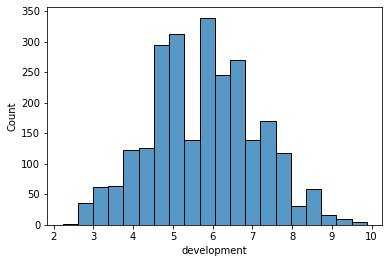

In [88]:
# show distribution of development

sns.histplot(data=tt19, x="development", bins=20)

### 3. Road Race 2016

In [89]:
# create development column

rr16_clean["development"] = ((rr16_clean["speed"]*1000/60) / rr16_clean["cadence"])
rr16_clean.loc[: , ["cadence", "speed", "development"]].sample(10)

,cadence,speed,development
2016-05-14 05:23:19+00:00,76.0,19.653366,4.309949
2016-05-14 04:50:58+00:00,84.0,29.173403,5.788374
2016-05-14 05:05:19+00:00,0.0,44.464947,inf
2016-05-14 04:13:04+00:00,89.0,29.876006,5.594758
2016-05-14 04:30:31+00:00,0.0,46.029687,inf
2016-05-14 04:09:19+00:00,70.0,31.222103,7.433834
2016-05-14 04:52:50+00:00,0.0,41.718666,inf
2016-05-14 04:47:03+00:00,90.0,32.027835,5.931081
2016-05-14 04:59:40+00:00,72.0,21.726212,5.029216
2016-05-14 05:23:00+00:00,75.0,24.407931,5.423985


In [90]:
# check summary statistics

rr16_clean["development"].describe()

count    2819.000000
mean             inf
std              NaN
min         2.872228
25%         5.636682
50%         6.727679
75%         8.362340
max              inf
Name: development, dtype: float64

In [91]:
# remove outliers and check if removed

rr16_clean = rr16_clean.drop(index = rr16_clean.index[(
    (rr16_clean["development"] < 2) | (rr16_clean["development"] > 10))])
rr16_clean["development"].describe()

count    2187.000000
mean        6.237114
std         1.159815
min         2.872228
25%         5.391031
50%         6.205279
75%         7.003120
max         9.976672
Name: development, dtype: float64

<AxesSubplot:xlabel='development', ylabel='Count'>

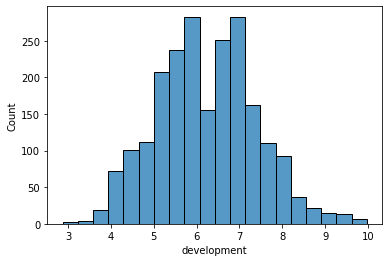

In [92]:
# show distribution

sns.histplot(data=rr16_clean, x="development", bins=20)

### 4. Road Race 2019

In [93]:
# create development column

rr19["development"] = ((rr19["speed"]*1000/60) / rr19["cadence"])
rr19.loc[: , ["cadence", "speed", "development"]].sample(10)

,cadence,speed,development
2019-06-22 23:59:05+00:00,81.0,18.851407,3.878890
2019-06-22 22:49:07+00:00,81.0,30.202294,6.214464
2019-06-22 22:50:07+00:00,65.0,25.673796,6.583025
2019-06-22 22:42:02+00:00,98.0,39.502165,6.718055
2019-06-22 23:39:46+00:00,88.0,32.414630,6.139134
2019-06-22 22:38:42+00:00,88.0,41.580656,7.875124
2019-06-22 23:42:33+00:00,88.0,26.438962,5.007379
2019-06-22 23:09:33+00:00,82.0,31.311104,6.364046
2019-06-22 23:22:58+00:00,63.0,29.608298,7.832883
2019-06-22 23:21:27+00:00,88.0,39.226962,7.429349


In [95]:
# check summary statistics

rr19["development"].describe()

count    5502.000000
mean             inf
std              NaN
min         3.218891
25%         5.731867
50%         6.773732
75%         8.730188
max              inf
Name: development, dtype: float64

In [97]:
# remove outliers and check if removed

rr19 = rr19.drop(index =
                rr19.index[(
                (rr19["development"] < 2) | (rr19["development"] > 10))])
rr19["development"].describe()

count    4307.000000
mean        6.331683
std         1.258009
min         3.218891
25%         5.437287
50%         6.425906
75%         7.003572
max         9.993942
Name: development, dtype: float64

<AxesSubplot:xlabel='development', ylabel='Count'>

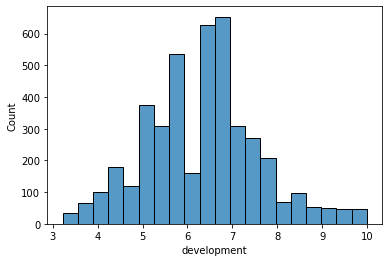

In [98]:
# show distribution

sns.histplot(data=rr19, x="development", bins=20)

### 5. Plot all distributions of development for comparison